Table of contents:

|No.|Topic|
|:------|:------|
|1.|[Idea 1](#section_id1)|
|2.|[Original Idea](#section_id2)|

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# for regressions with statsmodels:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.regressionplots import plot_leverage_resid2

# for regressions with scikit-learn:
import sklearn.linear_model as sklm
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_score, \
                            accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

#for plotting confusion matrix:
!pip install scikit-plot
import scikitplot as skplt

#for ordinal logistic regression
!pip install mord
from mord import LogisticIT

  Created wheel for mord: filename=mord-0.6-py3-none-any.whl size=6005 sha256=c960255cc978af059088b37305af5cb495a57fa9b7fe8d2e77640015ab9c90ad
  Stored in directory: /Users/shaneregel/Library/Caches/pip/wheels/80/1d/8a/bef1a01b6a3c91494905d161d5426c181819f9730a773141eb
Successfully built mord


In [4]:
#These are utility tools of the DMBA book. 
#Install the "dmba" package first (just one time)

!pip install dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import classificationSummary, gainsChart, liftChart
#from dmba.metric import AIC_score

no display found. Using non-interactive Agg backend


In [5]:
# visualization and tuning the aesthetics
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')
plt.rc('xtick', labelsize = 10) 
plt.rc('ytick', labelsize = 10) 
plt.rc('font', size = 12) 
plt.rc('figure', figsize = (6, 5))

<a id='section_id1'></a>
# Idea 1

In [6]:
pd.set_option("display.max_columns", None)
wv = pd.read_csv("worldvalues-data.csv", dtype='object', na_values = ['-5', '-4', '-3', '-2', '-1'])
wv.shape

(89565, 440)

In [7]:
wv = wv[["V55", "V58", "V95", "V145", "V229", "V246"]]
wv.describe()

,V55,V58,V95,V145,V229,V246
count,88117,87898,68199,84720,88038,89558
unique,10,9,10,7,8,5
top,8,No children,5,7,Full time,1
freq,16646,26142,19838,20631,28036,79300


In [8]:
wv.replace(['Missing', 'Unknown', 'Not asked', 'Not asked in suvey', 'Not applicable', 'No answer', 'Dont know'], np.nan, inplace=True)
wv.replace(['BH','HT','RU','AR','DE','PS','SE', 'SG', 'TR', 'HT: Dropped out survey; RU: Inappropriate response{Inappropriate}', 'Not asked in survey', 'DE,SE:Inapplicable ; RU:Inappropriate response; HT: Dropped out survey{Inappropriate}'], np.nan, inplace=True)
wv.replace({"V55":{"No choice at all" : 1, "A great deal of choice" : 10}}, inplace=True)
wv.replace({"V58":{"No children" : 0, "1 child" : 1, "2 children" : 2, "3 children" : 3, "4 children" : 4, "5 children" : 5, "6 children" : 6, "7 children" : 7, "8 or more children" : 8}}, inplace=True)
wv.replace({"V95":{"Left" : 1, "Right" : 10}}, inplace=True)
wv.replace({"V145":{"More than once a week" : 1, "Once a week" : 2, "Once a month" : 3, "Only on special holy days" : 4, "Once a year" : 5, "Less often" : 6, "Never, practically never" : 7}}, inplace=True)
wv.replace({"V229":{"Full time" : 1, "Part time" : 2, "Self employed" : 3, "Retired" : 4, "Housewife" : 5, "Students" : 6, "Unemployed" : 7, "Other" : 8}}, inplace=True)
wv[15:25]

,V55,V58,V95,V145,V229,V246
15,7,1,5,2,1,1
16,7,1,5,2,1,1
17,7,2,5,2,5,1
18,7,0,7,2,1,1
19,7,3,6,2,5,1
20,5,0,NaN,7,6,1
21,1,0,NaN,7,7,1
22,5,0,NaN,7,6,1
23,1,0,NaN,7,7,1
24,5,0,NaN,7,1,1


In [9]:
wv = wv.apply(pd.to_numeric)
wv.dropna(inplace=True)
wv.shape

(60981, 6)

In [10]:
wv.isna().sum()

V55     0
V58     0
V95     0
V145    0
V229    0
V246    0
dtype: int64

In [11]:
wv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60981 entries, 0 to 89564
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V55     60981 non-null  float64
 1   V58     60981 non-null  float64
 2   V95     60981 non-null  float64
 3   V145    60981 non-null  float64
 4   V229    60981 non-null  float64
 5   V246    60981 non-null  float64
dtypes: float64(6)
memory usage: 3.3 MB


In [12]:
wv = wv.rename(columns = {"V55" : "Freedom/Control", "V58" : "Number of Children", "V95" : "Political Scale", "V145" : "Religious Attendance", "V229" : "Employment status", "V246" : "Citizenship"})
wv.head()

,Freedom/Control,Number of Children,Political Scale,Religious Attendance,Employment status,Citizenship
0,7.0,0.0,5.0,3.0,6.0,1.0
1,6.0,0.0,5.0,2.0,6.0,1.0
2,6.0,0.0,6.0,2.0,3.0,1.0
3,6.0,0.0,6.0,2.0,1.0,1.0
4,6.0,3.0,5.0,1.0,3.0,1.0


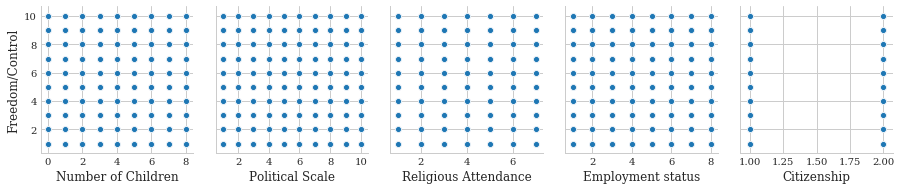

In [13]:
sns.pairplot(data=wv, y_vars=['Freedom/Control'], x_vars=['Number of Children', 'Political Scale', 'Religious Attendance', 'Employment status', 'Citizenship'])

/Users/shaneregel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:894: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/Users/shaneregel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:894: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


KeyboardInterrupt: 

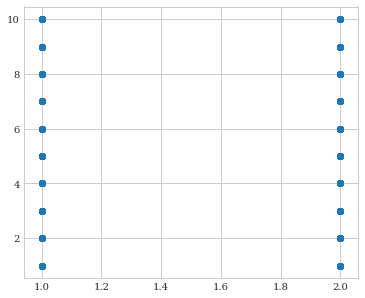

In [18]:
sns.regplot(x="Citizenship", y="Freedom/Control", data=wv, logistic=True, line_kws={"color": "red"})

In [19]:
wv.corr()

,Freedom/Control,Number of Children,Political Scale,Religious Attendance,Employment status,Citizenship
Freedom/Control,1.000000,0.012033,0.129813,-0.028194,-0.079685,-0.014762
Number of Children,0.012033,1.000000,0.081514,-0.106547,0.002992,-0.007951
Political Scale,0.129813,0.081514,1.000000,-0.106098,0.005354,-0.020422
Religious Attendance,-0.028194,-0.106547,-0.106098,1.000000,-0.067711,0.025131
Employment status,-0.079685,0.002992,0.005354,-0.067711,1.000000,-0.014217
Citizenship,-0.014762,-0.007951,-0.020422,0.025131,-0.014217,1.000000


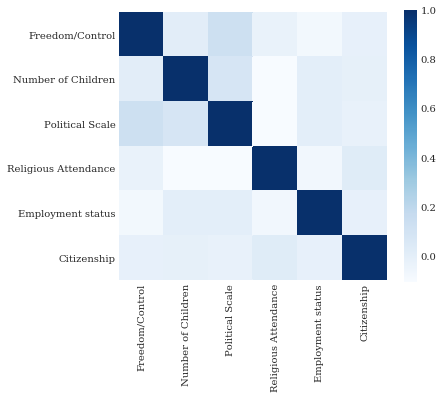

In [20]:
corrmat = wv.corr()
sns.heatmap(corrmat, square = True, cmap="Blues")

In [22]:
#Set up:
y = wv['Freedom/Control']
X = wv.drop(columns=['Freedom/Control'])
train_X2, valid_X2, train_y2, valid_y2 = train_test_split(X, y, test_size=0.4, random_state=1)
print(train_X2.shape, train_y2.shape)
print(train_X2.shape, valid_y2.shape)

(36588, 5) (36588,)
(36588, 5) (24393,)


In [23]:
lreg=sklm.LogisticRegression(solver='liblinear')
lreg.fit(train_X2, train_y2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
lreg.intercept_[0]

-2.649856474468106

In [25]:
pd.DataFrame({'coefficients': lreg.coef_[0]}, index=X.columns)

,coefficients
Number of Children,0.028864
Political Scale,-0.149775
Religious Attendance,-0.000984
Employment status,0.141502
Citizenship,-0.693995


In [26]:
#get the predicted values in training:
lreg_predictions_tr=lreg.predict(train_X2)
lreg_predictions_tr[:5]

array([ 8.,  8.,  8., 10., 10.])

In [27]:
#get the predicted probabilities in training:
lreg_predict_prob_tr=lreg.predict_proba(train_X2) # predictions for training set as probability values
lreg_predict_prob_tr

array([[0.04625567, 0.01886354, 0.03881603, ..., 0.16963446, 0.08924761,
        0.14032755],
       [0.02719675, 0.01530259, 0.03714492, ..., 0.19458247, 0.0971475 ,
        0.1848706 ],
       [0.01997274, 0.01211425, 0.03118551, ..., 0.21508906, 0.10819474,
        0.18376646],
       ...,
       [0.02803554, 0.01505329, 0.0332434 , ..., 0.18768634, 0.09819745,
        0.19527749],
       [0.01939399, 0.0110892 , 0.02807216, ..., 0.21906098, 0.11268535,
        0.17573392],
       [0.02452681, 0.01457778, 0.03469854, ..., 0.19801758, 0.10037909,
        0.19192748]])

In [28]:
logit_result_tr = pd.DataFrame({'actual': train_y2, 
                             'p(0)': [p[0] for p in lreg_predict_prob_tr],
                             'p(1)': [p[1] for p in lreg_predict_prob_tr],
                             'predicted': lreg_predictions_tr })

In [29]:
#highest probability of getting personal loan:
logit_result_tr.sort_values(by='p(1)', ascending=False).head()

,actual,p(0),p(1),predicted
24815,5.0,0.083621,0.039209,5.0
23817,1.0,0.083621,0.039209,5.0
24845,6.0,0.084134,0.038123,5.0
23935,4.0,0.082064,0.037563,5.0
24056,5.0,0.085056,0.035987,5.0


In [30]:
#lowest probability of getting personal loan:
logit_result_tr.sort_values(by='p(1)').head()

,actual,p(0),p(1),predicted
78893,8.0,0.004547,0.003601,8.0
22760,7.0,0.004547,0.003601,8.0
78430,10.0,0.004843,0.003880,8.0
79941,10.0,0.004843,0.003880,8.0
79189,8.0,0.005489,0.004007,8.0


In [31]:
# This is the from DMBA book package
classificationSummary(train_y2, lreg_predictions_tr)

Confusion Matrix (Accuracy 0.2072)

       Prediction
Actual    0    1    2    3    4    5    6    7    8    9
     0    0    0    0    0  137    0   29  583    0  256
     1    0    0    0    0   30    0   11  307    0  124
     2    0    0    0    0   65    0   22  725    0  237
     3    0    0    0    0   71    0   30 1076    0  346
     4    0    0    0    0  154    0   75 3181    0  994
     5    0    0    0    0   97    0  103 3074    0 1059
     6    0    0    0    0  134    1  111 4422    0 1392
     7    0    0    0    0  140    0  103 5266    0 1683
     8    0    0    0    0   73    0   69 2733    0 1027
     9    0    0    0    0  270    0   93 4236    0 2049


In [32]:
# This is a utility from scikit
print("Classification Report:\n",classification_report(train_y2, lreg_predictions_tr))

Classification Report:
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      1005
         2.0       0.00      0.00      0.00       472
         3.0       0.00      0.00      0.00      1049
         4.0       0.00      0.00      0.00      1523
         5.0       0.13      0.03      0.06      4404
         6.0       0.00      0.00      0.00      4333
         7.0       0.17      0.02      0.03      6060
         8.0       0.21      0.73      0.32      7192
         9.0       0.00      0.00      0.00      3902
        10.0       0.22      0.31      0.26      6648

    accuracy                           0.21     36588
   macro avg       0.07      0.11      0.07     36588
weighted avg       0.13      0.21      0.12     36588



/Users/shaneregel/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


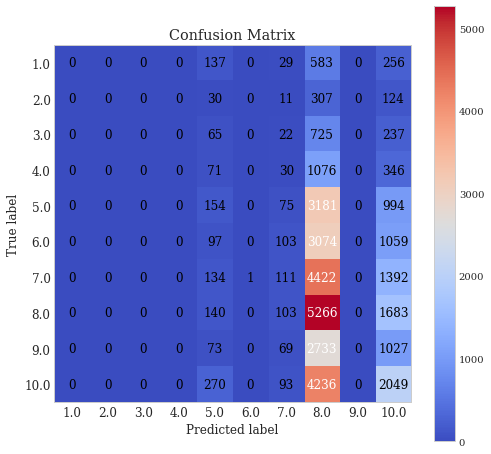

In [34]:
# You can plot the confusion matrix:
skplt.metrics.plot_confusion_matrix(train_y2, lreg_predictions_tr, figsize=(8,8), cmap="coolwarm")

In [35]:
# How good is the model on the validation dataset?
lreg_predictions_tt=lreg.predict(valid_X2)

In [36]:
print("Classification Report:\n",classification_report(valid_y2, lreg_predictions_tt))

Classification Report:
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       670
         2.0       0.00      0.00      0.00       343
         3.0       0.00      0.00      0.00       647
         4.0       0.00      0.00      0.00      1014
         5.0       0.12      0.03      0.05      2884
         6.0       0.33      0.00      0.00      2962
         7.0       0.17      0.02      0.03      4163
         8.0       0.20      0.73      0.31      4714
         9.0       0.00      0.00      0.00      2612
        10.0       0.22      0.30      0.25      4384

    accuracy                           0.20     24393
   macro avg       0.10      0.11      0.07     24393
weighted avg       0.16      0.20      0.12     24393



/Users/shaneregel/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


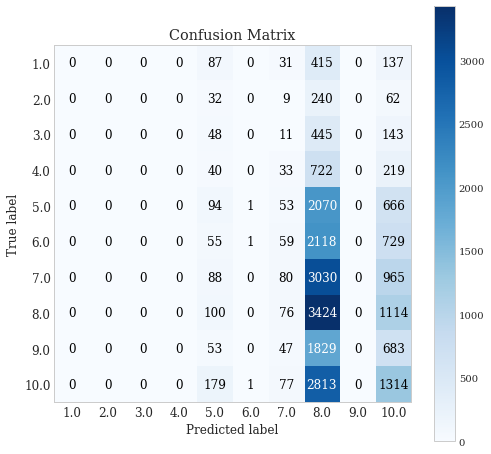

In [38]:
skplt.metrics.plot_confusion_matrix(valid_y2, lreg_predictions_tt, figsize=(8,8), cmap="Blues")

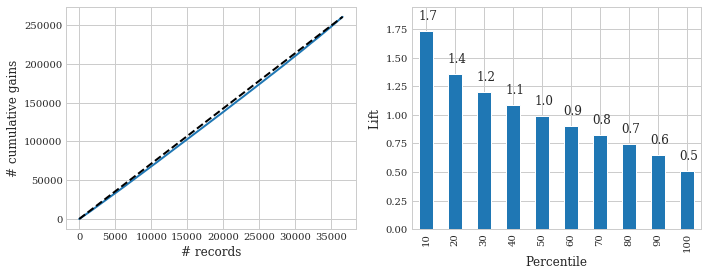

In [40]:
dfgains = logit_result_tr.sort_values(by='p(1)', ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(dfgains.actual, ax=axes[0])
liftChart(dfgains['p(1)'], title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()

<a id='section_id2'></a>
# Original Idea

In [44]:
pd.set_option("display.max_columns", None)
wv2 = pd.read_csv("worldvalues-data.csv", dtype='object', na_values = ['-5', '-4', '-3', '-2', '-1'])
wv2.shape

(89565, 440)

In [45]:
wb_incomes = pd.read_csv("worldbank_incomegroups.csv")
wb_incomes.shape

(218, 2)

In [46]:
# replace world bank country labels with those matching the world values dictionary
wb_incomes.replace({"Taiwan, China" : "Taiwan", "Hong Kong SAR, China" : "Hong Kong", "Egypt, Arab Rep." : "Egypt", "Korea, Rep." : "South Korea", "Kyrgyz Republic" : "Kyrgstan", "Russian Federation": "Russia", "Yemen, Rep." : "Yemen"}, inplace=True)
pd.set_option('display.max_rows', 500)
wb_incomes

,country,income_group
0,Afghanistan,Low
1,Benin,Low
2,Burkina Faso,Low
3,Burundi,Low
4,Central African Republic,Low
5,Chad,Low
6,"Congo, Dem. Rep",Low
7,Eritrea,Low
8,Ethiopia,Low
9,"Gambia, The",Low


In [48]:
wv_incomes = pd.merge(wv2, wb_incomes, left_on ="V2", right_on = "country", how="left")
wv_incomes

,V1,V2,V2A,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V44_ES,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V56_NZ,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V74B,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125_00,V125_01,V125_02,V125_03,V125_04,V125_05,V125_06,V125_07,V125_08,V125_09,V125_10,V125_11,V125_12,V125_13,V125_14,V125_15,V125_16,V125_17,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V160A,V160B,V160C,V160D,V160E,V160F,V160G,V160H,V160I,V160J,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V203A,V204,V205,V206,V207,V207A,V208,V209,V210,V211,V212,V213,V214,V215_01,V215_02,V215_03,V215_04,V215_05,V215_06,V215_07,V215_08,V215_10,V215_11,V215_12,V215_13,V215_14,V215_15,V215_16,V215_17,V215_18,V216,V217,V218,V219,V220,V221,V222,V223,V224,V218_ESMA,V217_ESMA,V219_ESMA,V220_ESMA,V221_ESMA,V222_ESMA,V223_ESMA,V224_ESMA,V225,V226,V227,V228,V228_2,V228A,V228B,V228C,V228D,V228E,V228F,V228G,V228H,V228I,V228J,V228K,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V243_AU,V244,V244_AU,V245,V246,V247,V248,V248_CS,V249,V250,V251,V252,V253,V253_CS,V254,V255,V256,V256B,V256C,V257,V258,V258A,V260,V261,V262,V265,Y001,Y001_1,Y001_2,Y001_3,Y001_4,Y001_5,Y002,Y003,MN_35A,MN_163A,MN_163B,MN_163C,MN_228L,MN_228M,MN_228N,MN_228O,MN_228P,MN_228Q,MN_228R,MN_228S1,MN_228S2,MN_228S3,MN_228S4,MN_228S5,MN_228S6,MN_228S7,MN_228S8,MN_229A,MN_229B,MN_230A,MN_233A,MN_233B,MN_234A,MN_237A,MN_237B1,MN_237B2,MN_237B3,MN_237B4,MN_237B5,MN_237B6,MN_237B7,MN_237C1,MN_237C2,MN_237C3,MN_237C4,MN_237C5,MN_237C6,MN_249A1,MN_249A2,MN_249A3,SACSECVAL,SECVALWGT,RESEMAVAL,WEIGHTB,I_AUTHORITY,I_NATIONALISM,I_DEVOUT,DEFIANCE,WEIGHT1A,I_RELIGIMP,I_RELIGBEL,I_RELIGPRAC,DISBELIEF,WEIGHT2A,I_NORM1,I_NORM2,I_NORM3,RELATIVISM,WEIGHT3A,I_TRUSTARMY,I_TRUSTPOLICE,I_TRUSTCOURTS,SCEPTICISM,WEIGHT4A,I_INDEP,I_IMAGIN,I_NONOBED,AUTONOMY,WEIGHT1B,I_WOMJOB,I_WOMPOL,I_WOMEDU,EQUALITY,WEIGHT2B,I_HOMOLIB,I_ABORTLIB,I_DIVORLIB,CHOICE,WEIGHT3B,I_VOICE1,I_VOICE2,I_VOI2_00,VOICE,WEIGHT4B,S001,S007,S018,S019,S021,S024,S025,COW,country,income_group
0,2010-2013,Algeria,Algeria,1,1,1,1,No answer,1,1,2,1,1,1,2,2,2,2,2,2,2,1,2,8,2,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,1,2,2,1,1,Not asked,1,Not asked,1,1,1,1,1,1,1,1,7,4,Not asked in survey,Single,No children,10,2,3,1,3,3,1,1,1,1,1,Very much like me,Very much like me,Very much like me,Very much like me,Very much like me,Like me,Like me,Very much like me,Like me,Somewhat like me,Somewhat like me,Discrimination against girls and women,1,2,2,4,No answer,No answer,No answer,No answer,No answer,NaN,NaN,NaN,NaN,NaN,5,8,7,6,8,7,5,2,2,2,2,2,2,1,3,3,2,3,2,2,4,3,3,2,3,2,3,4,4,3,Not asked in survey,Not asked in survey,Not asked in survey,4,Not asked in survey,Not asked in survey,Not asked in survey,Not asked in survey,Not asked in survey,Not asked in survey,Not asked in survey,Not asked in survey,Not asked in survey,Not asked in survey,Not asked in survey,Not asked in survey,0,0,4,1,2,2,2,3,8,5,6,9,3,4,7,6,7,5,2,2,Muslim,Once a month,Several times each week,1,1,1,No answer,No answer,10,1,2,2,1,2,7,4,3,2,3,1,9,1,2,1,2,2,Neither agree nor disagree,Disagree a little,Neither agree nor disagree,Disagree a little,Disagree strongly,Disagree a little,Disagree a little,Neither agree nor disagree,Disagree a little,Disagree a little,2,2,2,2,2,2,5,5,1,5,1,2,2,3,2,3,3,2,3,3,3,3,7,8,3,5,6,9,6,6,Never justifiable,Never justifiable,Never justif

In [49]:
# reduce data to columns relevant to opinions on government
wv_gov = wv_incomes[["V2", "V126", "V127", "V128", "V129", "V130", "income_group"]]
wv_gov

,V2,V126,V127,V128,V129,V130,income_group
0,Algeria,4,1,2,2,2,Upper-middle
1,Algeria,3,1,3,2,1,Upper-middle
2,Algeria,2,1,3,2,2,Upper-middle
3,Algeria,3,2,3,4,3,Upper-middle
4,Algeria,3,2,3,4,2,Upper-middle
...,...,...,...,...,...,...,...
89560,Zimbabwe,2,4,2,4,1,Lower-middle
89561,Zimbabwe,1,4,2,4,1,Lower-middle
89562,Zimbabwe,1,4,2,4,1,Lower-middle
89563,Zimbabwe,1,4,1,4,1,Lower-middle


In [50]:
# rename columns for readability
wv_gov = wv_gov.rename(columns = {"V2" : "Country", "V126" : "Confidence in United Nations", "V127" : "Favor Strong Leader", "V128" : "Support Expert Decision Makers", "V129" : "Favor Army Rule", "V130" : "Favor Democracy", "income_group" : "Income Group"})
wv_gov

,Country,Confidence in United Nations,Favor Strong Leader,Support Expert Decision Makers,Favor Army Rule,Favor Democracy,Income Group
0,Algeria,4,1,2,2,2,Upper-middle
1,Algeria,3,1,3,2,1,Upper-middle
2,Algeria,2,1,3,2,2,Upper-middle
3,Algeria,3,2,3,4,3,Upper-middle
4,Algeria,3,2,3,4,2,Upper-middle
...,...,...,...,...,...,...,...
89560,Zimbabwe,2,4,2,4,1,Lower-middle
89561,Zimbabwe,1,4,2,4,1,Lower-middle
89562,Zimbabwe,1,4,2,4,1,Lower-middle
89563,Zimbabwe,1,4,1,4,1,Lower-middle


In [51]:
# turn non answers into NaN
wv_gov.replace(['Missing', 'Unknown', 'Not asked in suvey', 'Not applicable', 'No answer', 'Dont know'], np.nan, inplace=True)
wv_gov.replace(['BH','HT','RU','AR','DE','PS','SE', 'SG', 'TR', 'HT: Dropped out survey; RU: Inappropriate response{Inappropriate}', 'Not asked in survey', 'DE,SE:Inapplicable ; RU:Inappropriate response; HT: Dropped out survey{Inappropriate}'], np.nan, inplace=True)
wv_gov[44:50]

,Country,Confidence in United Nations,Favor Strong Leader,Support Expert Decision Makers,Favor Army Rule,Favor Democracy,Income Group
44,Algeria,4,NaN,2,NaN,NaN,Upper-middle
45,Algeria,3,2,2,3,1,Upper-middle
46,Algeria,4,3,2,3,1,Upper-middle
47,Algeria,3,3,2,3,1,Upper-middle
48,Algeria,NaN,NaN,NaN,NaN,NaN,Upper-middle
49,Algeria,4,3,3,2,1,Upper-middle


In [52]:
wv_gov.isna().sum()

Country                               0
Confidence in United Nations      10752
Favor Strong Leader                7979
Support Expert Decision Makers     8900
Favor Army Rule                    9957
Favor Democracy                    6566
Income Group                       2500
dtype: int64

In [53]:
wv_gov.dropna(inplace=True)
wv_gov.shape

(66169, 7)

In [54]:
wv_gov.isna().sum()

Country                           0
Confidence in United Nations      0
Favor Strong Leader               0
Support Expert Decision Makers    0
Favor Army Rule                   0
Favor Democracy                   0
Income Group                      0
dtype: int64

In [55]:
wv_gov.replace({"Income Group":{"Low" : 1, "Lower-middle" : 2, "Upper-middle" : 3, "High" : 4}}, inplace=True)

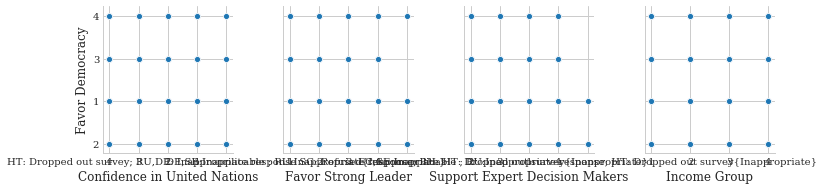

In [56]:
sns.pairplot(wv_gov, y_vars=['Favor Democracy'], x_vars=['Confidence in United Nations', 'Favor Strong Leader', 'Support Expert Decision Makers', 'Income Group'])

In [57]:
wv_gov.corr()

,Income Group
Income Group,1.0
